# Single Lightcurve Playground

This notebook tests out different smoothing algorithms to remove variability from lightcurves.

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
from analysis_tools_cython import *
from scipy.signal import savgol_filter
import pylab

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (11.0, 8.0)
plt.rcParams['font.size'] = 16

In [4]:
table = import_lightcurve('/storage/astro2/phsqzm/TESS/SPOC_30min/S06/target/0000/0002/7057/7175/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits')

---

In [5]:
from astropy.timeseries import LombScargle

In [6]:
table

TIME,PDCSAP_FLUX,QUALITY
float64,float32,int32
1468.3041536038627,5507612.0,0
1468.3249869523263,5507246.5,0
1468.34582030044,5507478.5,0
1468.3666536480885,5508482.0,0
1468.4083203422217,5507866.5,0
1468.4291536885903,5507848.0,0
1468.4499870347247,5507829.0,0
1468.4708203803937,5507612.0,0
1468.4916537255983,5508535.0,0


In [7]:
#min_freq = 1/(table['TIME'][-1] - table['TIME'][0])
#nyquist_freq = len(table['TIME'])/2*(table['TIME'][-1] - table['TIME'][0])

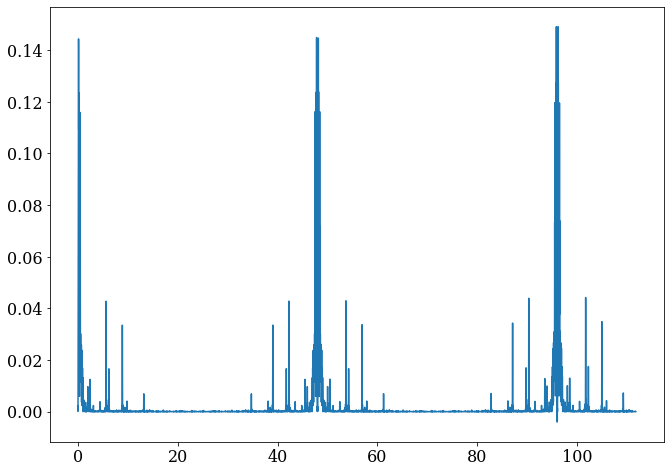

In [8]:
freq, p = LombScargle(table['TIME'],table['PDCSAP_FLUX']).autopower()
plt.plot(freq,p)

## Savitzky-Golay
### SPOC 30 min

In [9]:
y_smooth = savgol_filter(normalise_lc(table['PDCSAP_FLUX']),99,3,mode='nearest')

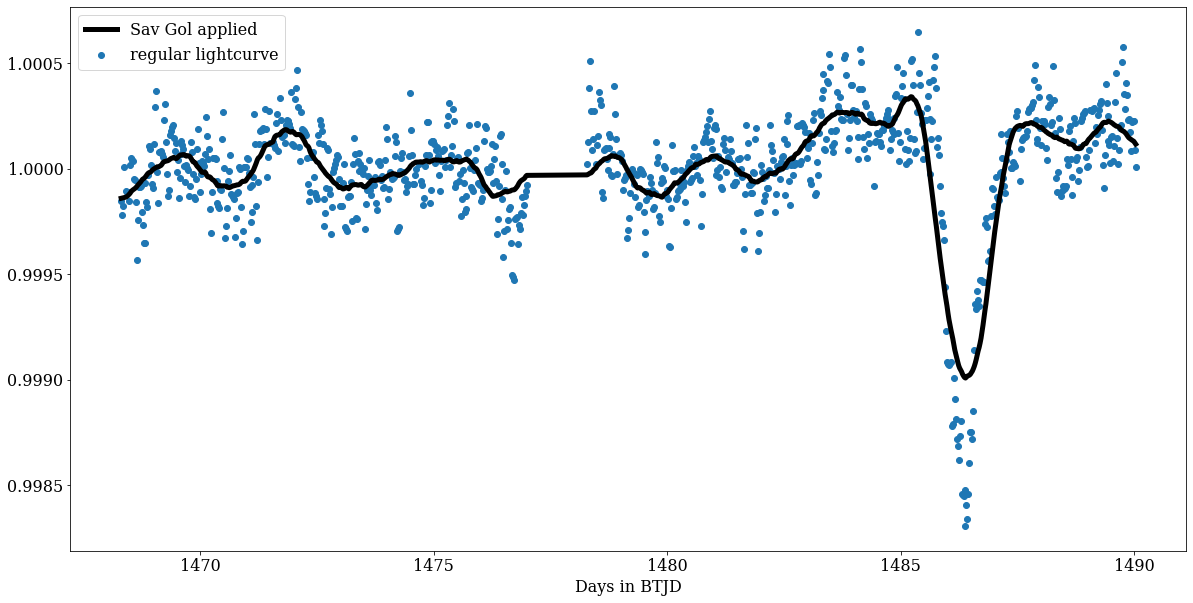

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(table['TIME'],normalise_lc(table['PDCSAP_FLUX']),label='regular lightcurve')
plt.plot(table['TIME'],y_smooth,linewidth=5,label='Sav Gol applied',color='k')
plt.xlabel('Days in BTJD')
plt.legend()
plt.show()

### 2-min SPOC

In [11]:
betapic = import_lightcurve('tess_testlcs/spoc_2min/S6/tess2018349182459-s0006-0000000270577175-0126-s_lc.fits',drop_bad_points=True)

In [12]:
y_smooth2min = savgol_filter(normalise_lc(betapic['PDCSAP_FLUX']),99,2)

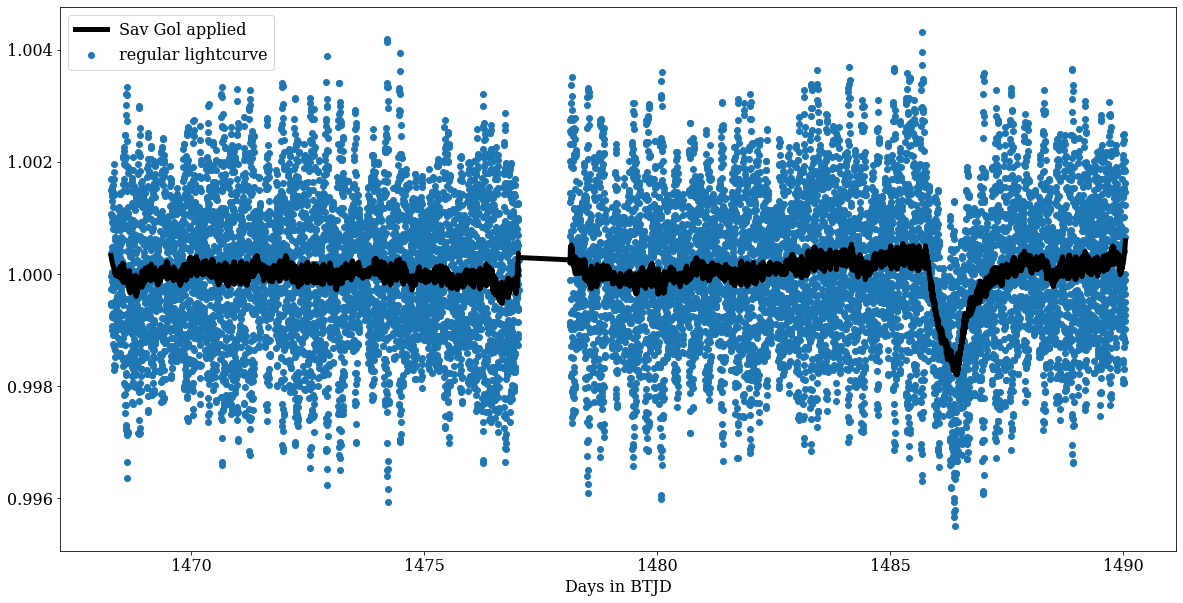

In [13]:
plt.figure(figsize=(20,10))
plt.scatter(betapic['TIME'],normalise_lc(betapic['PDCSAP_FLUX']),label='regular lightcurve')
plt.plot(betapic['TIME'],y_smooth2min,linewidth=5,label='Sav Gol applied',color='k')
plt.xlabel('Days in BTJD')
plt.legend()
plt.show()

### Kepler

In [14]:
data = import_lightcurve('kepler/kplr003542116-2012088054726_llc.fits')

In [15]:
y_smooth_kepler = savgol_filter(normalise_lc(data['PDCSAP_FLUX']),99,2)

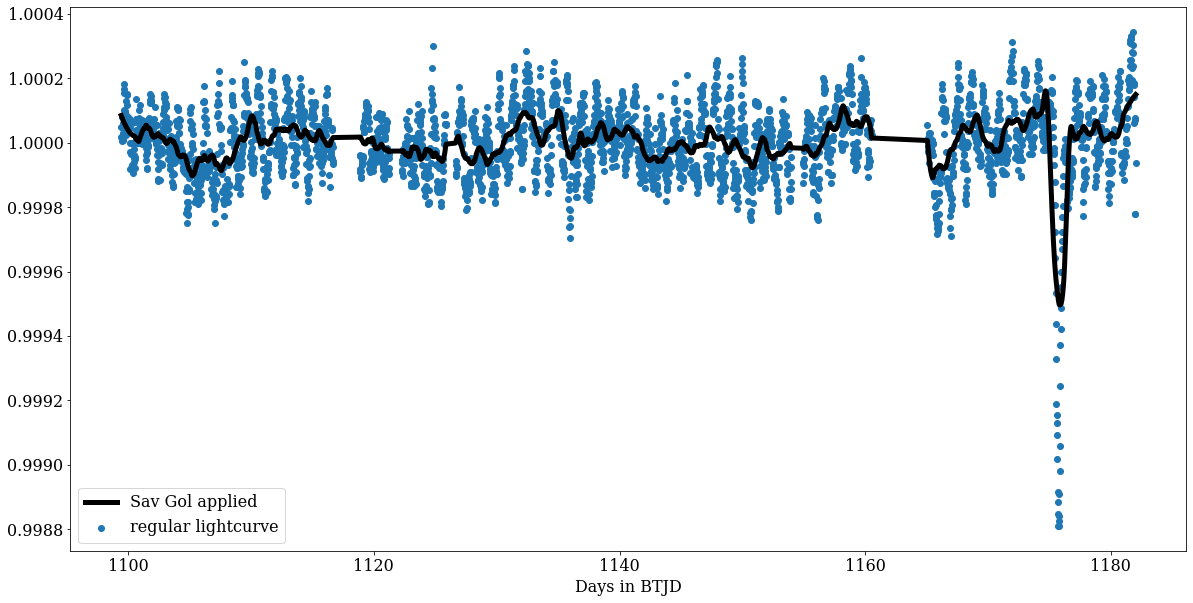

In [16]:
plt.figure(figsize=(20,10))
plt.scatter(data['TIME'],normalise_lc(data['PDCSAP_FLUX']),label='regular lightcurve')
plt.plot(data['TIME'],y_smooth_kepler,linewidth=5,label='Sav Gol applied',color='k')
plt.xlabel('Days in BTJD')
plt.legend()
plt.show()

---

In [17]:
import loaders

In [18]:
lc, _ = import_XRPlightcurve('betapic/tesslcs_sector_6_104_2_min_cadence_targets_tesslc_270577175.pkl',clip=4,sector=6,return_type='pandas')

---

### Testing on lightkurve

In [19]:
import lightkurve as lk

In [20]:
search = lk.search_lightcurve('Beta Pictoris',mission='TESS')
lck = search[6].download()

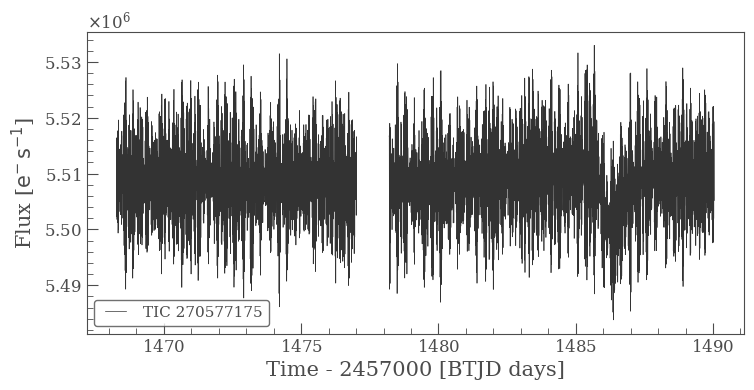

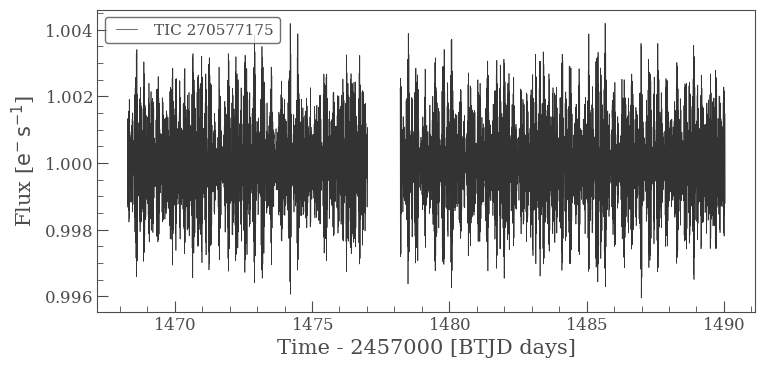

In [21]:
lck.plot()
lck.flatten().plot()

Interesting. Removes dip. Testing scipy `savgol_filter`:

In [22]:
test_smooth = savgol_filter(lck.sap_flux,199,2)

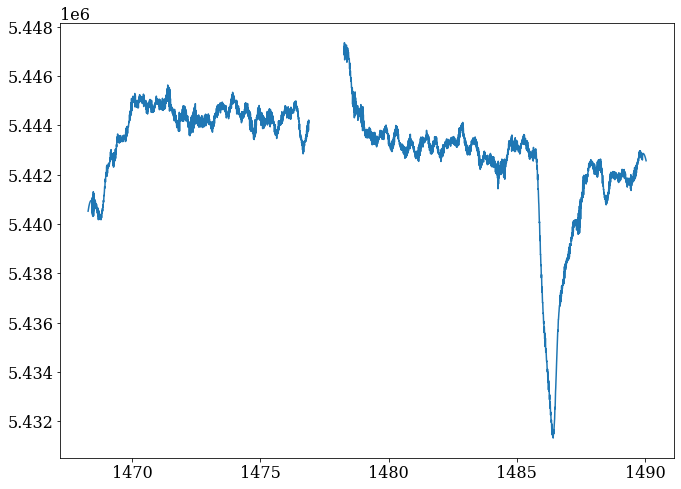

In [23]:
plt.plot(lck.time.value,test_smooth)

---

### XRP Lightcurve test

random import of lightcurve to check if mad threshold + sigma clipping has worked

In [24]:
lc, _ = import_XRPlightcurve('/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_159670453.pkl',sector=1,clip=4)
lc_no, _ = import_XRPlightcurve('/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_159670453.pkl',sector=1,clip=4,drop_bad_points=False)

In [25]:
q = lc['PCA flux'] == 0

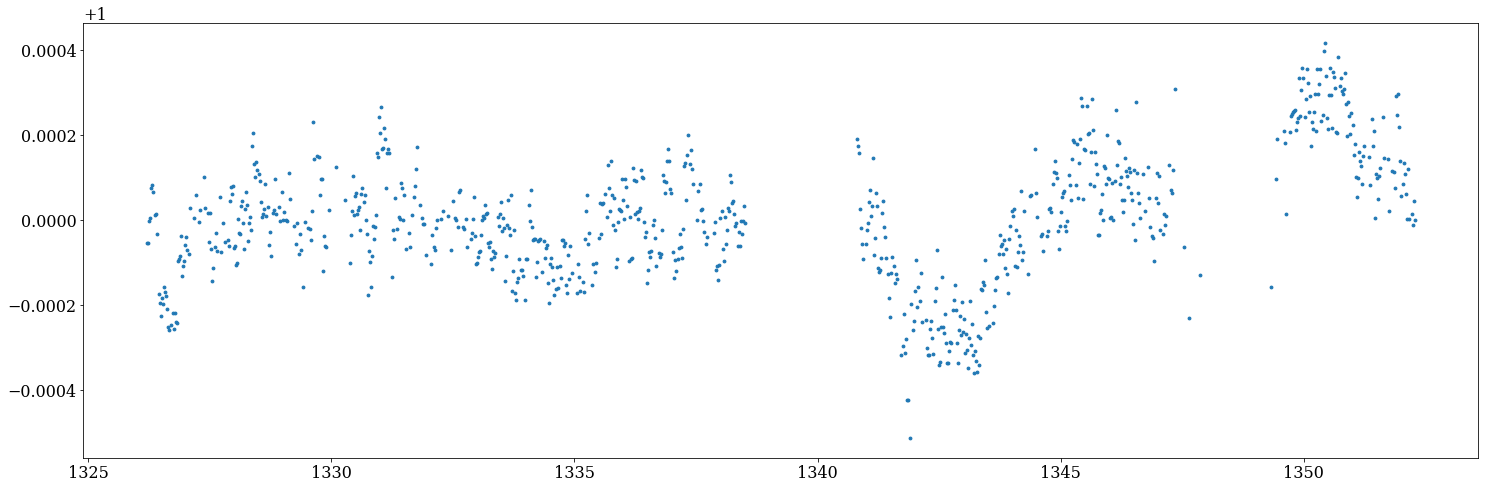

In [26]:
plt.figure(figsize=(25,8))
plt.scatter(lc['time'],normalise_lc(lc['PCA flux']),s=8)
#plt.plot(lc_no['time'],normalise_lc(lc_no['PCA flux']))

---

## LOWESS

In [27]:
import statsmodels.api as sm
from scipy.interpolate import interp1d

In [28]:
test = sm.nonparametric.lowess((table['PDCSAP_FLUX']),table['TIME'],frac=0.02)

In [29]:
test

array([[1.46830415e+03, 5.50754833e+06],
       [1.46832499e+03, 5.50761930e+06],
       [1.46834582e+03, 5.50768885e+06],
       ...,
       [1.48999152e+03, 5.50915742e+06],
       [1.49001235e+03, 5.50902922e+06],
       [1.49003318e+03, 5.50890084e+06]])

In [30]:
test.shape

(971, 2)

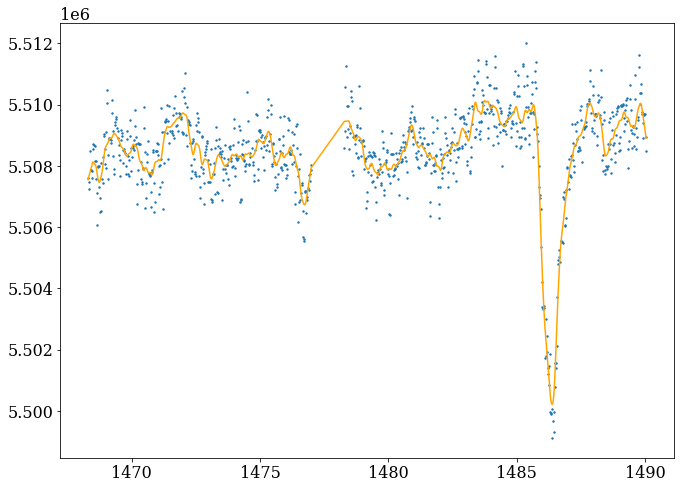

In [31]:
plt.scatter(table['TIME'],table['PDCSAP_FLUX'],s=2)
plt.plot(test[:,0],test[:,1],c='orange')

- Confidence interval: we have a fit now, but we need to know how precise it is.

In [32]:
def lowess_with_confidence_bounds(x, y, eval_x, N=len(table['TIME']), conf_interval=0.95, lowess_kw=None):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

In [33]:
smoothed, bottom, top = lowess_with_confidence_bounds(
    table['TIME'], table['PDCSAP_FLUX'], table['TIME'], lowess_kw={"frac": 0.02})

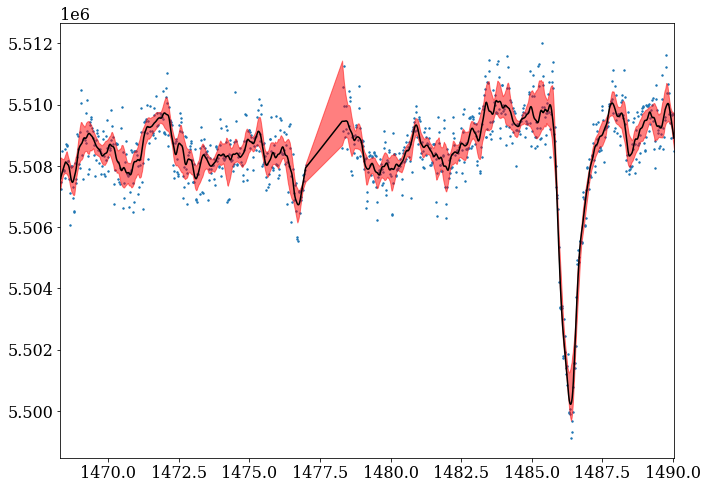

In [34]:
fig, ax = pylab.subplots()
ax.scatter(table['TIME'], table['PDCSAP_FLUX'],s=2)
ax.plot(table['TIME'], smoothed, c="k")
ax.fill_between(table['TIME'], bottom, top, alpha=0.5, color="r")
pylab.autoscale(enable=True, axis="x", tight=True)

---

## LOESS

In [35]:
!pip install loess

In [36]:
import loess

In [37]:
xout, yout, wout = loess_1d(table['TIME'],table['PDCSAP_FLUX'], degree = 2, frac=0.05)

NameError: name 'loess_1d' is not defined